# Camera Pose Estimation with OpenCV

### Goal

The goal of this notebook is to estimate the camera pose w.r.t. a reference object of known geometry such as a chessboard.

* Input: intrinsic parameter $K$, an image of a reference object (e.g. chessboard) and its 3D geometry
* Output: camera pose $R, t$ w.r.t. the reference object

Given a set of 2D-3D correspondences, the below solves a Perspective-n-Point (PnP) problem and obtain $R, t$ that satisfy $\tilde{x} \sim K (R|t)\tilde{X}$.


## Libraries

In [1]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera


## Calibration parameters

**Important**
* Compare the pattern shown below with the pattern captured in the image.
* The numbers of rows and cols indicate **the numbers of CELLs, not corners**.
  * For example, an 18x9 ChAruco board has a 18 cells == 17 corners by 9 cells == 8 corners pattern.
  * In the case of the traditional chessboard, the rows and cols indicate the numbers of corners.

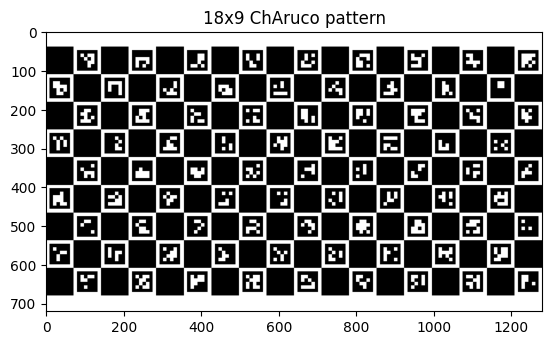

In [2]:
# Chessboard configuration
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((18, 9), 0.02, 0.015, aruco_dict)

# check if the board is correct
image = board.generateImage((1280, 720))

plt.figure()
plt.imshow(image, cmap='gray')
plt.title('18x9 ChAruco pattern')
plt.show()

# Input images capturing the chessboard above
input_files = '../data/charuco/*.jpg'


## Intrinsic Parameter

Use `incalib_charuco.ipynb` to get the intrinsic parameter.

In [3]:
K =  np.array([[586.95061044,   0.,         640.86534378],
               [  0.,         586.95061044, 356.28253051],
               [  0.,           0.,           1.        ]])

d =  np.array([[ 7.05473303e-01, -6.29813665e-01,  3.09176103e-04, -4.94115621e-04,
                -6.19825160e-02,  1.00148301e+00, -5.36482898e-01, -2.13796237e-01]])


print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) = ", d)


Intrinsic parameter K =  [[586.95061044   0.         640.86534378]
 [  0.         586.95061044 356.28253051]
 [  0.           0.           1.        ]]
Distortion parameters d = (k1, k2, p1, p2, k3, k4, k5, k6) =  [[ 7.05473303e-01 -6.29813665e-01  3.09176103e-04 -4.94115621e-04
  -6.19825160e-02  1.00148301e+00 -5.36482898e-01 -2.13796237e-01]]


## 2D chesscorner detection and PnP

Translation : [[-0.15283912]
 [-0.08830154]
 [ 0.1876779 ]]
Rotation    : [[-0.0617182 ]
 [-0.42753046]
 [ 0.07779836]]
Distance from camera: 0.2576430649397896 m


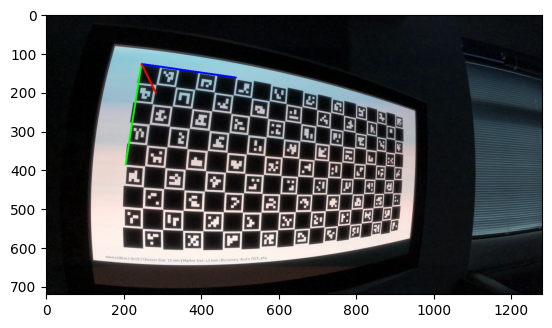

Translation : [[-0.29863116]
 [-0.082219  ]
 [ 0.21328504]]
Rotation    : [[0.0838318 ]
 [0.01214352]
 [0.02109415]]
Distance from camera: 0.3760731865302721 m


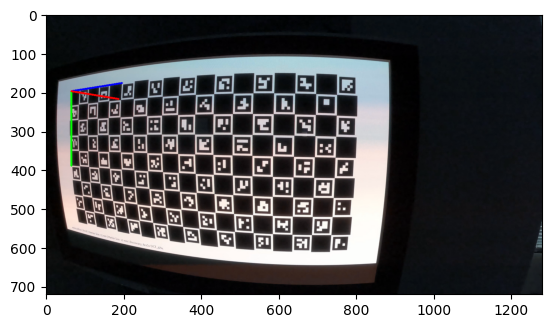

Translation : [[-0.08424419]
 [-0.08613594]
 [ 0.17227243]]
Rotation    : [[ 0.06467624]
 [-0.30429065]
 [ 0.0829325 ]]
Distance from camera: 0.21022434266475504 m


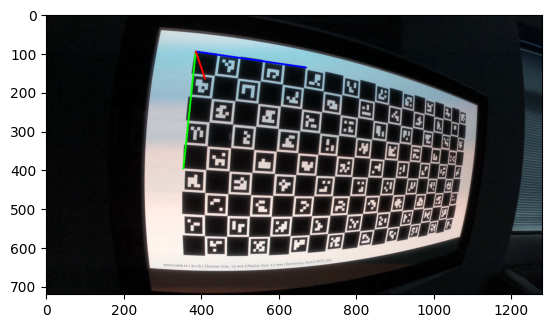

Translation : [[-0.09016792]
 [-0.11072853]
 [ 0.20427785]]
Rotation    : [[-0.24150075]
 [-0.13053095]
 [-0.01244292]]
Distance from camera: 0.24923984664436305 m


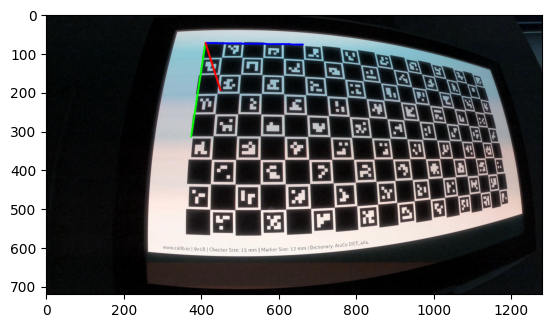

Translation : [[-0.18161978]
 [-0.07190078]
 [ 0.3211353 ]]
Rotation    : [[-0.22432624]
 [ 0.28125532]
 [-0.03791271]]
Distance from camera: 0.37587676789664337 m


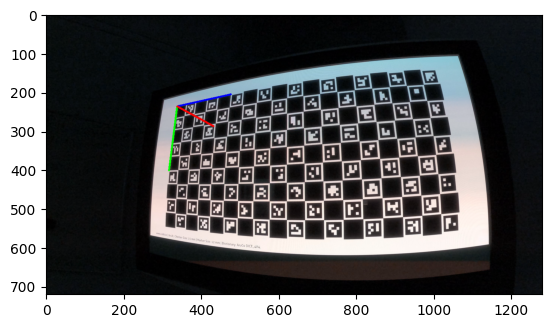

Translation : [[-0.2468983 ]
 [-0.07801172]
 [ 0.34746678]]
Rotation    : [[-0.07730729]
 [ 0.17971991]
 [ 0.00422384]]
Distance from camera: 0.4333333205050621 m


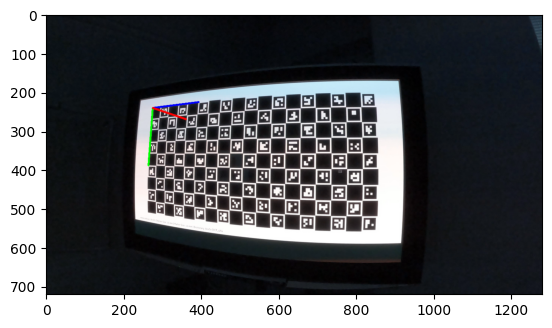

Translation : [[-0.11399194]
 [-0.0540649 ]
 [ 0.19262821]]
Rotation    : [[ 0.05074964]
 [-0.50153646]
 [-0.0145451 ]]
Distance from camera: 0.23026680483528722 m


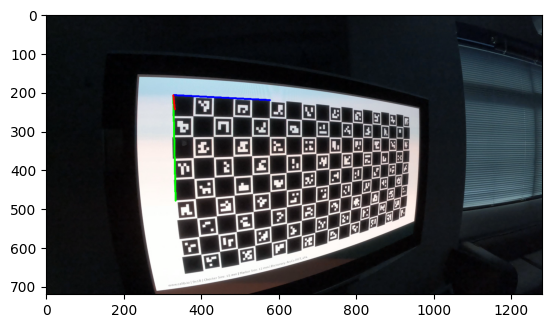

Translation : [[-0.31849576]
 [-0.10155025]
 [ 0.27215947]]
Rotation    : [[ 0.20787915]
 [ 0.07941886]
 [-0.07544788]]
Distance from camera: 0.43107166488901244 m


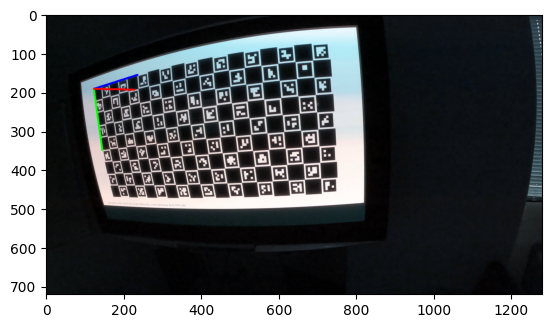

Translation : [[-0.18704673]
 [-0.11058635]
 [ 0.25117914]]
Rotation    : [[-0.28189728]
 [-0.11136343]
 [-0.01150498]]
Distance from camera: 0.33212464346155957 m


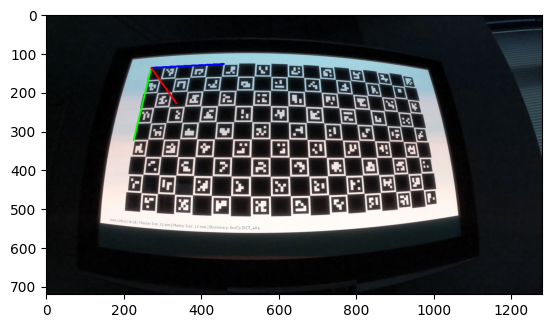

In [9]:
parameters = cv2.aruco.DetectorParameters()
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
detector = cv2.aruco.CharucoDetector(board, detectorParams=parameters)

for i in sorted(glob(input_files)):
    frame = cv2.imread(i)
    try:
        c_corners, c_ids, corners, ids = detector.detectBoard(frame)
        objPoints, imgPoints = board.matchImagePoints(c_corners, c_ids)
        ret, p_rvec, p_tvec = cv2.solvePnP(objPoints, imgPoints, K, d)
        
        if p_rvec is None or p_tvec is None:
            continue
        if np.isnan(p_rvec).any() or np.isnan(p_tvec).any():
            continue
        cv2.drawFrameAxes(frame,
                        K,
                        d,
                        p_rvec,
                        p_tvec,
                        0.1)
        # cv2.aruco.drawDetectedCornersCharuco(frame, c_corners, c_ids)
        # cv2.aruco.drawDetectedMarkers(frame, corners, ids)
        # cv2.aruco.drawDetectedMarkers(frame, rejected_points, borderColor=(100, 0, 240))
    except cv2.error:
        continue

    print('Translation : {0}'.format(p_tvec))
    print('Rotation    : {0}'.format(p_rvec))
    print('Distance from camera: {0} m'.format(np.linalg.norm(p_tvec)))

    plt.figure()
    plt.imshow(frame)
    plt.show()
